CIFAR10 é dataset de 50.000 imagens coloridas de treinamento com resolução de 32x32 e 10.000 imagens de teste, rotuladas em 10 categorias.

Agora, a partir dos conhecimentos adquiridos até o momento, realizem a redução de dimensionalidade do dataset CIFAR10, comparando as técnicas e seus resultados. Após a redução, implementem uma rede neural para a classificação utilizando cada conjunto de dados(Normal, PCA, AE e VAE).

Como sempre, escrevam com capricho o trabalho, apresentem a análise exploratória, fundamentação, metodologia, resultados, discussões e conclusões, avaliando qualitativa e quantitativamente o desempenho do modelo gerado, utilizando todos os conceitos e métodos até aqui aprendidos.

Referência: https://keras.io/api/datasets/cifar10/

In [ ]:
import re
import numpy as np
import datetime
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Reshape, Input, PReLU, ReLU, Lambda
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.layers import Conv1D, MaxPooling1D, BatchNormalization
from tensorflow.keras.layers import Dense, Activation, Dropout, LSTM, GRU, Conv2D, Conv2DTranspose, MaxPooling2D, Flatten, SimpleRNN, ConvLSTM2D, RepeatVector, TimeDistributed
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import SGD, Adam
from IPython.display import Markdown, display
from sklearn.decomposition import PCA

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import classification_report 

import matplotlib.pyplot as plt
%matplotlib inline 

In [ ]:
def convert_to_1darray(data):
  return data.reshape((data.shape[0], np.prod(data.shape[1:])))

In [ ]:
def PCA_method(X, n_components):
  pca = PCA(n_components=n_components)
  new_X = pca.fit_transform(X)
  pca_reconstructed = pca.inverse_transform(new_X)
  MSE = mean_squared_error(X, pca_reconstructed)
  MAE = mean_absolute_error(X, pca_reconstructed)
  variance = pca.explained_variance_ratio_.sum()

  display(Markdown("""
  <center>
  <b>PCA</b>

  |  Métrica  |  Valor |
  |:----------|:------:|
  |    MSE    |  %.2f  |
  |    MAE    |  %.2f  |
  | Variância |  %.2f  |

  </center>
  """ % (MSE, MAE, variance)))

  return new_X

In [ ]:
# reparametrization trick
def sampling(args):
    z_mean, z_log_var = args
    
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    
    epsilon = K.random_normal(shape=(batch, dim))
    
    s = K.exp(0.5 * z_log_var)
    
    return z_mean + s * epsilon

def vae_method(X, Y, n_components):
  (x_train, y_train), (x_val, y_val), (x_test, y_test) = split_phases(X, Y)
  latent_dimension = n_components

  encoder_input = Input(shape=(x_train.shape[1:]))
  x = conv_block(encoder_input, 128, 3)
  x = conv_block(x, 128, 3, 1)
  x = conv_block(x, 64, 3, 1)
  x = conv_block(x, 3, 3)
  x = Flatten() (x)
  x = Dense(latent_dimension) (x)
  encoder = Model(encoder_input, x, name = 'encoder')
  encoder.summary()

  z_mean = Dense(units=latent_dimension, name="z_mean") (x)
  z_log_var = Dense(units=latent_dimension, name="z_log_var") (x)
  z = Lambda(sampling, name="z")([z_mean, z_log_var])
  encoder = Model(encoder_input, z, name='encoder')

  decoder_input = Input(shape=(latent_dimension,))
  x = Dense(latent_dimension) (decoder_input)
  x = ReLU() (x)
  x = Reshape((8, 8, 3)) (x)
  x = deconv_block(x, 64, 3)
  x = deconv_block(x, 64, 3, 1)
  x = deconv_block(x, 128, 3, 1)
  x = deconv_block(x, 128, 3, 1)
  x = deconv_block(x, 3, 3)

  decoder = Model(decoder_input, x, name='decoder')
  decoder.summary()

  outputs = decoder(encoder(encoder_input))
  vae = Model(encoder_input, outputs, name='variational_autoencoder')
  vae.compile(loss='mse', metrics=['mae'], optimizer='adam')
  vae.summary()

  history = vae.fit(
    x=x_train,
    y=x_train,
    batch_size=6,
    epochs=50,
    validation_split=0.3,
    verbose=1
  )
  fig, ax = plt.subplots(ncols=len(vae.metrics_names), figsize=(12,5))

  for i, metric in enumerate(vae.metrics_names):
      ax[i].plot(history.history[metric], label=metric, c='r')
      ax[i].plot(history.history['val_'+metric], label='val_'+metric, c='k')
      ax[i].legend()
  
  plt.show()

  evals = vae.evaluate(x_test, x_test, verbose=0)
    
  Markdown("""Variational Autoencoder

  |  Métrica  |  Valor |
  |:----------|:------:|
  |    MSE    |  %.2f  |
  |    MAE    |  %.2f  |

  </center>
  """ % (evals[0], evals[1]))

  encoder.compile(loss='mse', metrics=['mae'], optimizer='adam')
  new_X = encoder.predict(X)
    
  return np.array(new_X, dtype = np.float)
  

In [ ]:
def conv_block(x, filters, kernel_size, strides=2):
   x = Conv2D(filters=filters,
              kernel_size=kernel_size,
              strides=strides,
              padding='same')(x)
   x = BatchNormalization()(x)
   x = ReLU()(x)
   return x
def deconv_block(x, filters, kernel_size, strides = 2):
   x = Conv2DTranspose(filters=filters,
                       kernel_size=kernel_size,
                       strides=strides,
                       padding='same')(x)
   x = BatchNormalization()(x)
   x = ReLU()(x)
   return x

In [ ]:
def ae_method(X, Y, n_components):

    (x_train, y_train), (x_val, y_val), (x_test, y_test) = split_phases(X, Y)

    encoder_input = Input(shape=(x_train.shape[1:]))
    x = conv_block(encoder_input, 128, 3)
    x = conv_block(x, 128, 3, 1)
    x = conv_block(x, 64, 3, 1)
    x = conv_block(x, 3, 3)
    encoder = Model(encoder_input, x, name = 'encoder')
    encoder.summary()

    decoder_input = Input(shape=(8, 8, 3))
    x = deconv_block(decoder_input, 64, 3)
    x = deconv_block(x, 128, 3, 1)
    x = deconv_block(x, 3, 3)

    decoder = Model(decoder_input, x, name='decoder')
    decoder.summary()

    outputs = decoder(encoder(encoder_input))
    ae = Model(encoder_input, outputs, name='autoencoder')

    opt = SGD(lr=0.001, momentum=0.9)
    ae.compile(loss='mse', metrics=['mae'], optimizer=opt)
    ae.summary()

    history = ae.fit(
      x = x_train,
      y = x_train,
      batch_size = 128,
      epochs = 50,
      validation_split = 0.3,
      verbose = 1
    )
    
    fig, ax = plt.subplots(ncols=len(ae.metrics_names), figsize = (12,5))

    for i, metric in enumerate(ae.metrics_names):
        ax[i].plot(history.history[metric], label=metric, c='r')
        ax[i].plot(history.history['val_'+metric], label='val_'+metric, c='k')
        ax[i].legend()
        
    plt.show()

    evals = ae.evaluate(x_test, x_test, verbose=1)
    
    display(Markdown("""
    <center>
    <b>Autoencoder</b>

    |  Métrica  |  Valor |
    |:----------|:------:|
    |    MSE    |  %.2f  |
    |    MAE    |  %.2f  |

    </center>
    """ % (evals[0], evals[1])))

    encoder.compile(loss='mse', metrics=['mae'], optimizer='adam')
    new_X = encoder.predict(X)
    
    return np.array(new_X, dtype = np.float)

In [ ]:
def set_data(name_reduction):
  num_classes = 10
  (x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

  X = np.concatenate((x_train, x_test), axis = 0)
  Y = np.concatenate((y_train, y_test), axis = 0)

  w, h, c = X.shape[1:]

  n_components = (w * h * c) // 16
  X = np.array(X, dtype = np.float) / 255
  Y = tf.keras.utils.to_categorical(Y, num_classes)

  if name_reduction == "PCA":
    X = PCA_method(convert_to_1darray(X), n_components)
    X = X.reshape((-1, 8, 8, 3))
  elif name_reduction == "AE":
    X = ae_method(X, Y, n_components)
  elif name_reduction == "VAE":
    X = vae_method(X, Y, n_components)
    X = X.reshape((-1, 8, 8, 3))
  else:
    pass
  return split_phases(X, Y)
  

In [ ]:
def train_and_predict_script(train, val, test, summary = False):
  x_train, y_train = train
  x_val, y_val = val

  num_classes = y_train.shape[-1]
  input_shape = x_train.shape[1:]
  units = input_shape[0]

  model = Sequential()
  model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=input_shape))
  model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(MaxPooling2D((2, 2)))
  model.add(Dropout(0.2))
  model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(MaxPooling2D((2, 2)))
  model.add(Dropout(0.1))
  model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(MaxPooling2D((2, 2)))
  model.add(Dropout(0.2))
  model.add(Flatten())
  model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
  model.add(Dropout(0.2))
  model.add(Dense(10, activation='softmax'))

  opt = SGD(lr=0.001, momentum=0.9)
  model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

  if summary:
    model.summary()

  batch_size = 162
  epochs = 100

  history = model.fit(x_train, y_train,
                      batch_size=batch_size,
                      epochs=epochs,
                      verbose=1,
                      validation_data=(x_val, y_val))
  
  plot_predicts(history, model, test)


In [ ]:
def split_phases(X, Y):
  split = int(X.shape[0] * 5 / 6)
  x_train, x_test = X[:split], X[split:]
  y_train, y_test = Y[:split], Y[split:]

  x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.1)
  return (x_train, y_train), (x_val, y_val), (x_test, y_test)

In [ ]:
def plot_predicts(history, model, test):
  x_test, y_test = test
  # Plotando o historico do processo de treinamento
  plt.figure(figsize=(20, 5))
  plt.plot(history.history['loss'], color='blue')
  plt.plot(history.history['val_loss'], color='red')
  plt.title('Model loss', fontsize=20)
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['Treinamento', 'Validação'], loc='upper right', fontsize=14)
  plt.show()

  prediction = model.predict(x_test)
  prediction = list(map(lambda x : x.argmax(), prediction))
  y_target = list(map(lambda y : y.argmax(), y_test))

  class_labels = [
      "Plane",
      "Car",
      "Bird",
      "Cat",
      "Deer",
      "Dog",
      "Frog",
      "Horse",
      "Boat",
      "Truck"
  ]

  print(np.array(prediction).shape)
  print(np.array(y_target).shape)
  accuracy = accuracy_score(prediction, y_target)
  report = classification_report(y_target, prediction, target_names=class_labels)

  print('Acurácia: ', accuracy)
  print('Report:\n', report)

170508288/170498071 [==============================] - 2s 0us/step
Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 16, 16, 128)       3584      
_________________________________________________________________
batch_normalization (BatchNo (None, 16, 16, 128)       512       
_________________________________________________________________
re_lu (ReLU)                 (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 128)       147584    
_________________________________________________________________
batch_normalization_1 (Batch (None, 16, 16, 128)       512       
__________________________________________________________

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
encoder (Functional)         (None, 8, 8, 3)           227983    
_________________________________________________________________
decoder (Functional)         (None, 32, 32, 3)         79887     
Total params: 307,870
Trainable params: 306,834
Non-trainable params: 1,036
_________________________________________________________________
Epoch 1/50
247/247 [==============================] - 44s 54ms/step - loss: 0.1522 - mae: 0.2928 - val_loss: 0.1091 - val_mae: 0.2623
Epoch 2/50
247/247 [==============================] - 12s 49ms/step - loss: 0.1016 - mae: 0.2332 - val_loss: 0.0906 - val_mae: 0.2280
Epoch 3/50
247/247 [==============================] - 12s 50ms/step - loss: 0.0883 - mae: 0.2147 - val_loss

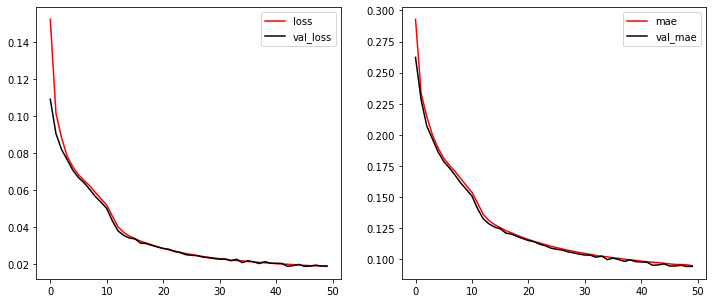

313/313 [==============================] - 3s 9ms/step - loss: 0.0190 - mae: 0.0943



    <center>
    <b>Autoencoder</b>

    |  Métrica  |  Valor |
    |:----------|:------:|
    |    MSE    |  0.02  |
    |    MAE    |  0.09  |

    </center>
    

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 8, 8, 32)          896       
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 8, 8, 32)          9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 4, 4, 32)          0         
_________________________________________________________________
dropout (Dropout)            (None, 4, 4, 32)          0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 4, 4, 64)          18496     
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 4, 4, 64)          36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 2, 2, 64)          0

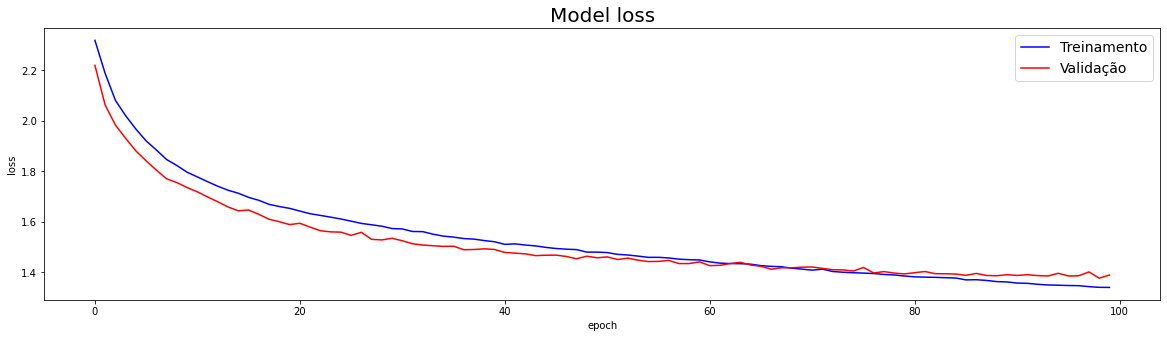

(10000,)
(10000,)
Acurácia:  0.51
Report:
               precision    recall  f1-score   support

       Plane       0.62      0.55      0.58      1000
         Car       0.61      0.65      0.63      1000
        Bird       0.40      0.31      0.35      1000
         Cat       0.33      0.24      0.28      1000
        Deer       0.43      0.39      0.41      1000
         Dog       0.43      0.47      0.45      1000
        Frog       0.49      0.69      0.57      1000
       Horse       0.52      0.61      0.56      1000
        Boat       0.66      0.64      0.65      1000
       Truck       0.55      0.56      0.56      1000

    accuracy                           0.51     10000
   macro avg       0.50      0.51      0.50     10000
weighted avg       0.50      0.51      0.50     10000



In [ ]:
train, val, test = set_data("AE")
train_and_predict_script(train, val, test, True)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 16, 16, 64)        18496     
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 16, 16, 64)        36928     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 8, 8, 64)         

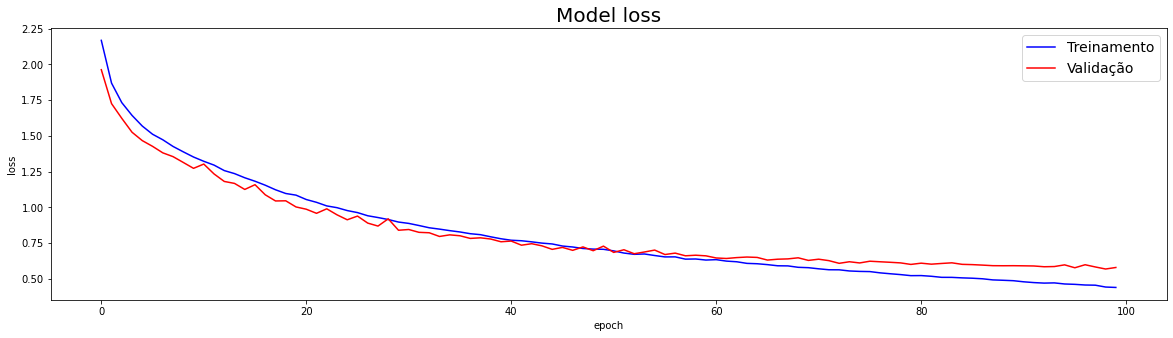

(10000,)
(10000,)
Acurácia:  0.793
Report:
               precision    recall  f1-score   support

       Plane       0.79      0.83      0.81      1000
         Car       0.87      0.90      0.89      1000
        Bird       0.73      0.69      0.71      1000
         Cat       0.67      0.60      0.63      1000
        Deer       0.76      0.77      0.77      1000
         Dog       0.72      0.70      0.71      1000
        Frog       0.74      0.91      0.82      1000
       Horse       0.84      0.83      0.84      1000
        Boat       0.90      0.87      0.88      1000
       Truck       0.90      0.84      0.87      1000

    accuracy                           0.79     10000
   macro avg       0.79      0.79      0.79     10000
weighted avg       0.79      0.79      0.79     10000



In [ ]:
train, val, test = set_data("Normal")
train_and_predict_script(train, val, test, True)


  <center>
  <b>PCA</b>

  |  Métrica  |  Valor |
  |:----------|:------:|
  |    MSE    |  0.00  |
  |    MAE    |  0.04  |
  | Variância |  0.94  |

  </center>
  

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 8, 8, 32)          896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 32)          9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 4, 4, 32)          0         
_________________________________________________________________
dropout (Dropout)            (None, 4, 4, 32)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 64)          18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 64)          36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 2, 2, 64)          0

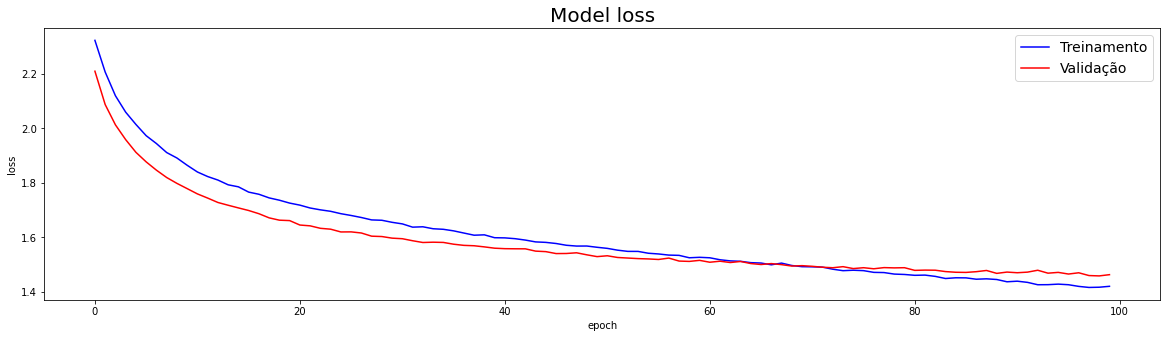

(10000,)
(10000,)
Acurácia:  0.4805
Report:
               precision    recall  f1-score   support

       Plane       0.58      0.54      0.56      1000
         Car       0.61      0.54      0.58      1000
        Bird       0.37      0.30      0.33      1000
         Cat       0.32      0.28      0.30      1000
        Deer       0.40      0.39      0.40      1000
         Dog       0.41      0.37      0.39      1000
        Frog       0.49      0.60      0.54      1000
       Horse       0.48      0.56      0.51      1000
        Boat       0.59      0.66      0.63      1000
       Truck       0.51      0.57      0.54      1000

    accuracy                           0.48     10000
   macro avg       0.48      0.48      0.48     10000
weighted avg       0.48      0.48      0.48     10000



In [ ]:
train, val, test = set_data("PCA")
train_and_predict_script(train, val, test, True)

170508288/170498071 [==============================] - 2s 0us/step
Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 16, 16, 128)       3584      
_________________________________________________________________
batch_normalization (BatchNo (None, 16, 16, 128)       512       
_________________________________________________________________
re_lu (ReLU)                 (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 128)       147584    
_________________________________________________________________
batch_normalization_1 (Batch (None, 16, 16, 128)       512       
__________________________________________________________

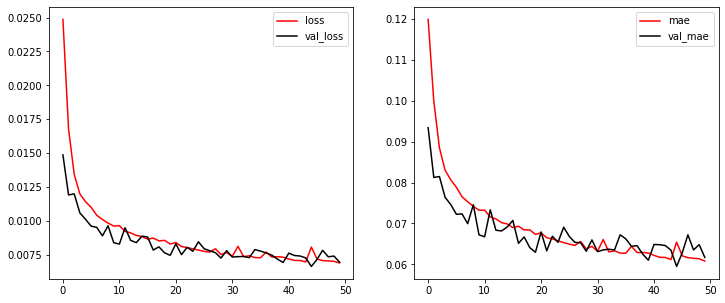

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 8, 8, 32)          896       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 8, 8, 32)          9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 4, 4, 32)          0         
_________________________________________________________________
dropout (Dropout)            (None, 4, 4, 32)          0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 4, 4, 64)          18496     
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 4, 4, 64)          36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 2, 2, 64)          0

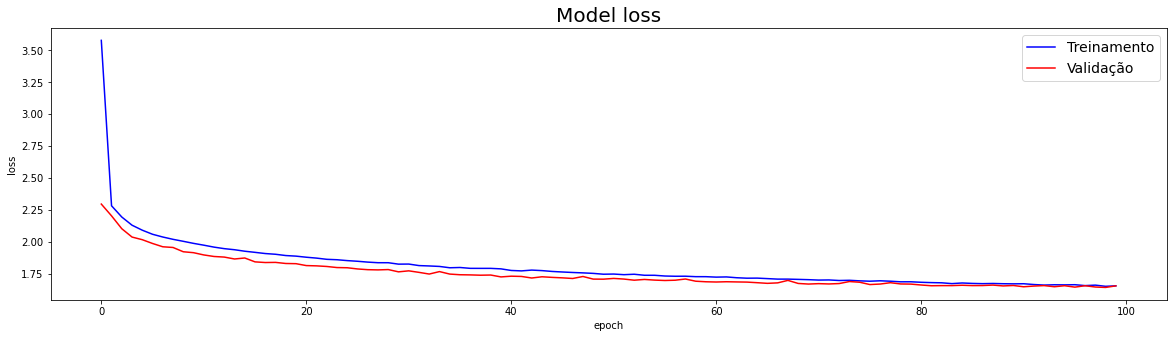

(10000,)
(10000,)
Acurácia:  0.4168
Report:
               precision    recall  f1-score   support

       Plane       0.44      0.55      0.49      1000
         Car       0.57      0.45      0.51      1000
        Bird       0.27      0.26      0.26      1000
         Cat       0.29      0.18      0.23      1000
        Deer       0.37      0.35      0.36      1000
         Dog       0.37      0.29      0.33      1000
        Frog       0.35      0.58      0.44      1000
       Horse       0.51      0.40      0.44      1000
        Boat       0.51      0.62      0.56      1000
       Truck       0.50      0.48      0.49      1000

    accuracy                           0.42     10000
   macro avg       0.42      0.42      0.41     10000
weighted avg       0.42      0.42      0.41     10000



In [ ]:
train, val, test = set_data("VAE")
train_and_predict_script(train, val, test, True)